<a href="https://colab.research.google.com/github/Siru-Song/tests/blob/main/run_maml_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Download dataset: Omniglot"""
download_omniglot = "./download_omniglot.sh"

!bash {download_omniglot}

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_05.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_06.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_07.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_08.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_09.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_10.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_11.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_12.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_13.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_14.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_15.png  
  inflating: ./omniglot/images_evaluation/Mongolian/character28/1386_16.png  
  inflating: ./omniglot/imag

In [2]:
!pip install opencv-python
!pip install scikit-image
!pip install more_itertools

In [3]:
"""Resize Omniglot images from 105x105 to 28x28"""
import os
import cv2 # !pip install opencv-python
path_from = "./omniglot/"
path_to = "./omniglot_mini/"

os.mkdir(path_to)
# ['images_background', 'images_evaluation']
D0 = sorted(os.listdir(path_from))
for d0 in D0:

    os.mkdir(os.path.join(path_to,d0))
    # ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', ...
    D1 = sorted(os.listdir(os.path.join(path_from,d0)))
    for d1 in D1:

        os.mkdir(os.path.join(path_to,d0,d1))
        # ['character01', 'character02', ...
        D2 = sorted(os.listdir(os.path.join(path_from,d0,d1)))
        for d2 in D2:

            os.mkdir(os.path.join(path_to,d0,d1,d2))
            # ['0709_01.png', '0709_02.png', ...
            D3 = sorted(os.listdir(os.path.join(path_from,d0,d1,d2)))
            for d3 in D3:

                x = cv2.imread(os.path.join(path_from,d0,d1,d2,d3), 0)
                x = cv2.resize(x, (28,28))
                cv2.imwrite(os.path.join(path_to,d0,d1,d2,d3), x)

## What is Omniglot?
- 50개의 alphabet으로 구성된 데이터셋입니다.
- "images_background" folder에는 30개의 alphabet, "images_evaluation" folder에는 20개의 alphabet으로 구성되어 있습니다.
- 본 실습에서는 이중 일부 데이터셋만 활용할 예정입니다.

Arcadian
Number of different characters in Alphabet folder: 26


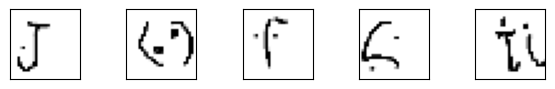

N_Ko
Number of different characters in Alphabet folder: 33


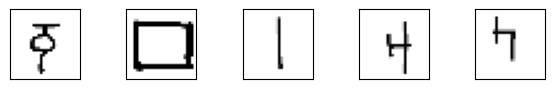

Gujarati
Number of different characters in Alphabet folder: 48


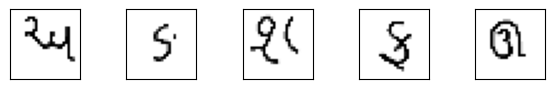

Japanese_(hiragana)
Number of different characters in Alphabet folder: 52


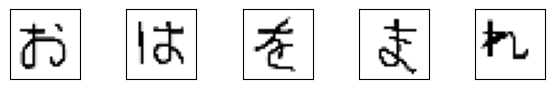

Japanese_(katakana)
Number of different characters in Alphabet folder: 47


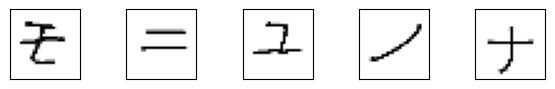

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import random
num_different_characters_to_show = 5
num_different_alphabets_to_show = 5
image_folders = "./omniglot_mini/images_background/"
alphabet_folders = os.listdir(image_folders)
alphabet_folders_sampled = random.sample(alphabet_folders,5)
# Plotting the images
for alphabet_folder in alphabet_folders_sampled:
    plt.figure(figsize=(6, 1))
    character_folders = os.listdir(os.path.join(image_folders, alphabet_folder))
    print(alphabet_folder)
    print("Number of different characters in Alphabet folder:", len(character_folders))
    sampled_character_folders = random.sample(character_folders, min(num_different_alphabets_to_show, len(character_folders)))
    for char_idx, character_path in enumerate(sampled_character_folders):
        character_folder_path = os.path.join(image_folders, alphabet_folder, character_path)
        character_folder = os.listdir(character_folder_path)
        selected_character_path = random.choice(character_folder)
        img_path = os.path.join(character_folder_path, selected_character_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Display the image
        plt.subplot(1, num_different_characters_to_show, char_idx+1)
        plt.imshow(img)
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import os
import random
import matplotlib.pyplot as plt
import numpy as np

from skimage import io # !pip install scikit-image (for skimage)
from skimage.transform import resize
from tqdm import tqdm
from time import sleep
from collections import OrderedDict
from more_itertools import chunked

n_shot = 1
n_class = 5
n_local_update = 5
batch_size = n_class

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [6]:
class OmniglotDataset(Dataset):
    def __init__(self, path_to_chars, train, train_indices, transform):

        self.data = []
        self.path = NotImplementedError

        for label_i, (path_to_label, train_index) in enumerate(zip(path_to_chars, train_indices)):
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # omniglot has 20 images per character
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = (image-0.92208)/0.25140
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

## Taskset and TaskLoader classes

In [7]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return len(self.taskset)

## Taskset

In [8]:
class OmniglotTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):

        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
            name_langs = ["Alphabet_of_the_Magi", "Anglo-Saxon_Futhorc",
                         "Arcadian", "Armenian", "Bengali", "Greek", "Japanese_(hiragana)",
                         "Korean", "Latin", "N_Ko"]
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
            name_langs = ["Angelic", "Atlantean", "Avesta", "Keble", "Mongolian",
                         "Sylheti", "Tengwar", "Tibetan"]

        chars = []

        for path_to_lang in name_langs:
            path_to_chars = os.path.join(path_to_langs, path_to_lang)
            for path_to_char in os.listdir(path_to_chars):
                chars.append(os.path.join(path_to_chars, path_to_char))

        random.shuffle(chars)
        tasks = list(chunked(chars, n_class))[:-1] # drop_last

        self.tasks = tasks

    def __len__(self):
        return len(self.tasks)

    def __getitem__(self, idx):
        train_indices = np.random.randint(20, size=(n_class, n_shot))
        return {"train":
                DataLoader(
                    OmniglotDataset(self.tasks[idx],
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "test":
                DataLoader(
                    OmniglotDataset(self.tasks[idx],
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx]
               }

## TaskLoader

67
['./omniglot_mini/images_background/Arcadian/character18', './omniglot_mini/images_background/Latin/character07', './omniglot_mini/images_background/Bengali/character27', './omniglot_mini/images_background/Latin/character12', './omniglot_mini/images_background/Armenian/character11']
train


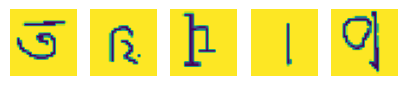

tensor([2, 0, 4, 3, 1])
test


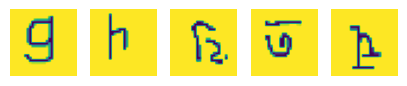

tensor([1, 4, 0, 2, 4])


In [9]:
meta_train_task_loader = TaskLoader(
    OmniglotTaskset("./omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(5,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
            plt.axis('off')
        plt.show()
        print(target)
    print("test")
    local_task_test_data_loader = meta_train_task["test"]
    for data, target in local_task_test_data_loader:
        plt.figure(figsize=(5,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
            plt.axis('off')
        plt.show()
        print(target)
        break
    break

## Few-shot task (5-way 1-shot)

![MAML Figure](./5way_1shot.png)

Image 출처: FLAP: A Semi-Supervised Few-Shot Learning Algorithm via Pseudo-Labeling (https://www.researchgate.net/publication/379843433_FLAP_A_Semi-Supervised_Few-Shot_Learning_Algorithm_via_Pseudo-Labeling)

## What is MAML?
- Model-Agnostic Meta-Learning(MAML)은 meta-learning의 한 방법입니다.
- MAML은 meta-learning을 통해 학습된 모델이 새로운 task에 대해 빠르게 학습할 수 있도록 학습합니다.
- MAML은 다음과 같은 과정으로 학습됩니다.
    1. meta-train set에서 (meta_train_train_set, meta_train_test_set)의 pair를 k 개 샘플링합니다.
    2. Inner loop (점선) \
                  - meta_train_train_set을 학습 데이터로 사용하여, 모델을 SGD로 1~10번 update합니다. \
                  - meta_train_test_set을 통해 loss를 계산하여 저장해 둡니다. \
                  - update된 모델은 버리고, 다시 inner loop를 돌리기 전의 모델로 회귀합니다.
    3. 2번 과정을 pair k개에 대해 반복합니다.
    4. Outer loop (실선) \
                  - 2 ~ 3 과정에서 얻어진 loss k개를 더한 뒤, 이 loss를 이용하여 모델을 SGD 업데이트합니다.

![MAML Figure](./MAML_figure.png)

![MAML Explanation](./MAML_explanation.png)

paper link: https://arxiv.org/pdf/2304.01552

## Model Architecture

In [10]:
class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()

        self.h=64
        self.conv1 = nn.Conv2d(1, self.h, kernel_size=3)
        self.conv2 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv3 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn2 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn3 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.fc = nn.Linear(self.h, n_class)

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.view(x.size(0), self.h)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

    # for MAML local optimization
    def manual_forward(self, x, params):

        x = F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn1.weight'], params['bn1.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)

        x = F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn2.weight'], params['bn2.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)

        x = F.conv2d(x, params['conv3.weight'].to(device), params['conv3.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn3.weight'], params['bn3.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)

        x = x.view(x.size(0), self.h)
        x = F.linear(x, params['fc.weight'].to(device), params['fc.bias'].to(device))
        x = F.log_softmax(x, dim=1)

        return x

def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_acc = 0

    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_data_loader.dataset)
    train_acc /= len(train_data_loader.dataset)
    return train_loss, train_acc

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    test_acc = 0

    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]

            test_loss += loss
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    test_acc /= len(test_data_loader.dataset)
    return test_loss, test_acc

## MAML algorithm

In [14]:
class MetaLearner(object):
    def __init__(self):
        self.inner_lr = 0.1
        self.momentum = 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.master_net = OmniglotNet(n_class).to(self.device)
        self.outer_lr = 0.0005
        self.keys = self.master_net.state_dict().keys()

    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)

    def save(self, model_path):
        torch.save(self.master_net.state_dict(), model_path)

    def load(self, model_path):
        self.master_net.load_state_dict(torch.load(model_path))

    def meta_test(self):

        meta_test_task_loader = TaskLoader(
            OmniglotTaskset("./omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

        test_loss, test_acc = [], []

        sleep(0.5)
        with tqdm(meta_test_task_loader, desc="Meta Test ", ncols=10) as _tqdm:
            for meta_test_task in _tqdm:

                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                # ---------------------------------------------- #
                # Hint. self.copy_params를 이용하여 self.master_net의 parameter를 faster_net으로 복사해 주세요.
                self.copy_params(self.master_net, faster_net)
                # ---------------------------------------------- #
                faster_opt = optim.SGD(faster_net.parameters(), lr=self.inner_lr, momentum=self.momentum)

                # make local task data loader
                local_task_train_data_loader = meta_test_task["train"]
                local_task_test_data_loader = meta_test_task["test"]


                ######## meta test task train
                for epoch in range(n_local_update):
                    _train_loss, _train_acc = train(
                        faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1,
                        train_loss="{:.3f}".format(_train_loss),
                        train_acc="{:.3f}".format(_train_acc)))

                ########  meta test task test
                _test_loss, _test_acc = test(faster_net, self.device, local_task_test_data_loader)
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)

        return np.mean(test_loss), np.mean(test_acc)


    def meta_train(self):

        meta_train_task_loader = TaskLoader(
            OmniglotTaskset("./omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))

        meta_grads = []

        test_loss, test_acc = [], []

        sleep(0.5)
        with tqdm(meta_train_task_loader, desc="Meta Train", ncols=10) as _tqdm:
            for meta_train_task in _tqdm:

                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                faster_net.forward = NotImplementedError
                # ---------------------------------------------- #
                # Hint. self.copy_params를 이용하여 self.master_net의 parameter를 faster_net으로 복사해 주세요.
                self.copy_params(self.master_net, faster_net)
                # ---------------------------------------------- #

                master_params = OrderedDict((name, param) for (name, param) in self.master_net.named_parameters())

                # make local task data loader
                local_task_train_data_loader = meta_train_task["train"]
                local_task_test_data_loader = meta_train_task["test"]


                ######## meta train task train
                first_train_for_this_task = True

                for data, target in local_task_test_data_loader:
                    break

                for epoch in range(n_local_update):

                    _train_loss = 0
                    _train_acc = 0

                    for data, target in local_task_train_data_loader:
                        data, target = data.to(self.device), target.to(self.device)

                        if first_train_for_this_task:
                            output = self.master_net(data)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]

                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()

                            grads = torch.autograd.grad(loss, self.master_net.parameters(), create_graph=True)

                            # ---------------------------------------------- #
                            # Hint. self.inner_lr을 이용하여 SGD를 구현해 주세요
                            faster_params = OrderedDict(
                                (name, self.inner_lr * grad)
                                for ((name, param), grad) in zip(master_params.items(), grads))
                            # ---------------------------------------------- #

                            first_train_for_this_task = False

                        else:
                            # ---------------------------------------------- #
                            # Hint. MAML inner loop 2~n번 째 update를 하는 곳입니다.
                            #       앞서, 지난 inner loop에서 구한 parameter를 사용하시면 됩니다.
                            output = faster_net.manual_forward(data, faster_params)
                            # ---------------------------------------------- #
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]

                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()

                            grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)

                            # ---------------------------------------------- #
                            # Hint. self.inner_lr을 이용하여 SGD를 구현해 주세요
                            faster_params = OrderedDict(
                                (name, self.inner_lr * grad)
                                for ((name, param), grad) in zip(faster_params.items(), grads))
                            # ---------------------------------------------- #

                    _train_loss /= len(local_task_train_data_loader.dataset)
                    _train_acc /= len(local_task_train_data_loader.dataset)

                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1,
                        train_loss="{:.3f}".format(_train_loss),
                        train_acc="{:.3f}".format(_train_acc)))

                ######## meta train task test
                _test_loss = 0
                _test_acc = 0

                # ---------------------------------------------- #
                # Hint. 다음 For loop는 MAML outer loop에 사용할 gradient를 계산하는 부분입니다.
                #       이때 어떤 dataloader를 사용해야 하는지 적어주세요.
                data_loader_for_test_task = local_task_test_data_loader
                # ---------------------------------------------- #
                for data, target in data_loader_for_test_task:
                    data, target = data.to(self.device), target.to(self.device)

                    output = faster_net.manual_forward(data, faster_params)
                    loss = F.nll_loss(output, target)

                    # differentiates test_loss by master_net params
                    grads = torch.autograd.grad(loss, self.master_net.parameters(), retain_graph=True)
                    grads = {name:g for ((name, _), g) in zip(faster_net.named_parameters(), grads)}
                    meta_grads.append(grads)

                    pred = output.max(1, keepdim=True)[1]
                    acc = pred.eq(target.view_as(pred)).sum()

                    _test_loss += loss.item()
                    _test_acc += acc.item()

                _test_loss /= len(data_loader_for_test_task.dataset)
                _test_acc /= len(data_loader_for_test_task.dataset)
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)

        ######## end all tasks


        ######## meta update: SGD with self.outer_lr
        meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}

        with torch.no_grad():
            for (k, v) in self.master_net.named_parameters():
                # ---------------------------------------------- #
                # Hint. self.outer_lr과 meta_grads를 이용하여 SGD를 구현해 주세요.
                # Hint 2. k 값을 잘 이용해 보아요 :)
                v -= self.outer_lr * meta_grads[k]
                # ---------------------------------------------- #

        return np.mean(test_loss), np.mean(test_acc)

## Run MAML

In [15]:
meta_learner = MetaLearner()

for _ in range(1):
    test_loss, test_acc = meta_learner.meta_test()
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        0, test_loss, test_acc))

for epoch in tqdm(range(100)):

    train_loss, train_acc = meta_learner.meta_train()
    test_loss, test_acc = meta_learner.meta_test()

    print("# {} (meta-train-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, train_loss, train_acc))
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, test_loss, test_acc))
    print()


Meta Test 


# 0  (meta-test-task) test_loss: 0.926194, test_acc: 0.677990


  0%|          | 0/100 [00:00<?, ?it/s]
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
Meta Train
  0%|          | 0/100 [00:05<?, ?it/s]


KeyboardInterrupt: 